# Angiography

Use this notebook for single animals, otherwise run it in batch from **GLUT1_Analysis**

In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import MRIhelperfunctions as h
import MRIhelperfunctions
from MRIhelperfunctions import Settings
from imp import importlib
import fnmatch
import papermill as pm

import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline  



from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



import niwidgets
from niwidgets import NiftiWidget
import nilearn.plotting as nip

importlib.reload(h)
import MRIhelperfunctions as h
from MRIhelperfunctions import Settings

## Manually set the folders below, will be overwritten when notebook is run from batch

In [2]:
# Default Parameters (to run script independently)
folders = {}
folders['raw'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata'
folders['main'] = os.path.dirname(folders['raw'])
folders['analysis'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Analysis'
folders['animal'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/20180604_101508_Glut1_2_2'
folders['excel'] = 'Animal_Scan_IDs.xlsx'


animal = 'glut1_male1'


info = h.getinfo(folders)
info

,glut1_male1,glut1_male2,glut1_f10wks1,glut1_f10wks2,glut1_f10wks3,glut1_f10wks4,glut1_f10wks5,glut1_f10wks6,glut1_f8wks1,glut1_f8wks2,glut1_f8wks3,glut1_f8wks4,glut1_f8wks5,glut1_f8wks6,glut1_f8wks7,glut1_f6wks2,glut1_f6wks1
scan,,,,,,,,,,,,,,,,,
Gd DCE,6,8,6,5,5,8,5,5,7,5,6,6,8,8,6,5,5
Angio pre,8,9,7,6,6,9,6,6,8,6,9,8,9,9,8,6,6
Angio post,12,12,11,9,9,13,10,11,12,11,12,12,16,13,12,9,10
Endorem DCE,11,11,10,8,8,12,9,10,10,10,11,11,15,12,11,8,9
Diamox,15,14,13,11,13,15,12,13,14,13,16,17,20,16,14,11,13
folder,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018060...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...,/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/2018061...


In [3]:
# additional Script specific parameters

info = pd.read_json(info)  #<-- dont run this line in single animal mode

folders['template'] = os.path.join(folders['main'], 'Templates', 'Angio_pre.nii' ) # from animal glut1_male1
folders['out'] = os.path.join(folders['analysis'], animal, 'Angiography')


## Convert and obtain the correct scans

In [4]:
#todo: allow some fuzzy word matching
scans={}
scans['pre_nr'] = int(info.loc['Angio pre', animal])
scans['post_nr'] = int(info.loc['Angio post', animal])

h.check_and_convert(folders, animal)

if not os.path.exists(folders['out']):
    os.makedirs(folders['out'] )

scans['pre'] = os.path.join(folders['analysis'], animal, f"X{scans['pre_nr']}P1.nii")
scans['post'] = os.path.join(folders['analysis'], animal, f"X{scans['post_nr']}P1.nii")


pre = nib.load(scans['pre'])
post = nib.load(scans['post'])
print(f'check if these dimensions make sense:  pre: {pre.shape}, post:  {post.shape}')

FileNotFoundError: No such file or no access: '/home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/X8P1.nii'

## Coregistration to template

In [5]:
# coregister to template
scans['pre_coreg'], scans['post_coreg'] = h.simple_coreg(folders['template'], scans['pre'], scans['post'], folders['out'])

## Signal Subtraction

In [81]:
# subtract post from pre
scans['post_min_pre'] = f"{folders['out']}/Post_minus_Pre_{animal}.nii"
factor = 10000  #<-- multiply values to prevent rounding errors (subtraction result is close to zero)
h.runAFNI(f"3dcalc -a {scans['post_coreg']}  -b {scans['pre_coreg']} -expr '(a-b)*{factor}' -prefix {scans['post_min_pre']}")

3dcalc -a /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Angiography/post_coreg+orig  -b /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Angiography/pre_coreg+orig -expr '(a-b)*10000' -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Angiography/Post_minus_Pre_glut1_male1.nii


In [85]:
# storing data in notebook to be consumed by main notebook later

pm.record("post_minus_pre", scans['post_min_pre'])

# Below some unfinished investigation tools

To be implemented:
- autmotacially detect number of vessels, determine size, length, etc.
- Currently, manual count in AFNI or ImageJ necessary

In [82]:
# load result and use header to calculate FOV, image cooridnates, etc.
img = nib.load(scans['post_min_pre'])
data = img.get_fdata()
hdr = img.header

dimensions = Settings()
dimensions.res = [hdr['pixdim'][1], hdr['pixdim'][2], hdr['pixdim'][3]]
dimensions.fov = [ dimensions.res[0]*(hdr['dim'][1]-1), dimensions.res[1]*(hdr['dim'][2]-1), dimensions.res[2]*(hdr['dim'][3]-1) ]
dimensions.min = [ -hdr['qoffset_x'], -hdr['qoffset_y'], hdr['qoffset_z']-dimensions.fov[2] ]
dimensions.max = [ -hdr['qoffset_x']+dimensions.fov[0], -hdr['qoffset_y']+dimensions.fov[1], float(hdr['qoffset_z']) ]


## Interactive plot to check result

In [80]:
@interact(y=(dimensions.min[1],dimensions.max[1],dimensions.res[1]),
          z=(dimensions.min[2],dimensions.max[2],dimensions.res[2]), continuous_update=False)
def plot_result(y,z):
    fig = plt.figure(figsize=(25,5))
#     coord = (-3,4)
    coord = (y,z)
    nip.plot_img(img, display_mode='yz', figure=fig, cut_coords=coord, cmap='gray')

interactive(children=(FloatSlider(value=0.14673669263720512, description='y', max=7.56181138381362, min=-7.208…

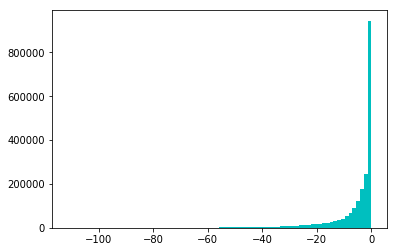

In [38]:
#threshold and check values. Don't forget multiplication factor for quantification

threshold = 10
# data[data <= threshold] = 0

plt.hist(data.flatten(), bins=80, color='c', range=(threshold, np.max(data)))
plt.show()

## Below just some unfinished experimental stuff

fig, axes = plt.subplots(1, 3, figsize=(5, 10))
for ii, ax in enumerate(axes):
    ax.set_facecolor('black')
    ax.tick_params(
        axis='both', which='both', bottom='off', top='off',
        labelbottom='off', right='off', left='off', labelleft='off'
        )
    # fix the axis limits
    axis_limits = [limit for jj, limit in enumerate(img.shape[:3])
                   if jj != ii]
    ax.set_xlim(0, axis_limits[0])
    ax.set_ylim(0, axis_limits[1])




my_widget = NiftiWidget(scans.post_min_pre)


# my_widget.nifti_plotter(figsize=(20,40))
my_widget.nifti_plotter(plotting_func=nip.plot_img, colormap=None, figsize=(5, 10),
                        figure=fig,
                        axes = axes)

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
#     p = image.transpose(2,1,0)
    p=image
    verts, faces, _, _  = measure.marching_cubes(p)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

plot_3d(data)